В целом этот код сгенерил GPT.
В нем реализован метод Рунге Кутты 4 порядка, используется разностная аппроксимация для производной по координате. 
В том числе из-за плохо подходящей для данной задачи разностной аппроксимации, в решениях наблюдаются сильные расхождения.

В программе также используются формулы для перехода к размерным величинам (в системе СИ) 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
rho0 = 1.225  # кг/м^3 (плотность воздуха на уровне моря)
p0   = 101325  # Па (атмосферное давление)
L0   = 1.0     # м (характерная длина)
U0   = np.sqrt(p0 / rho0) # м/с (характерная скорость, примерно скорость звука)
T0 = p0/(rho0*287) # K (Характерная температура)

def Conversion_in_Dim_quantities(x, rho, u, p, T):
    return x*L0, rho*rho0, u*U0, p*p0, T*T0

def Conversion_in_Dim_less_quantities(x, rho, u, p, T):
    return x/L0, rho/rho0, u/U0, p/p0, T/T0

def ConversionTime_in_Dim(t):
    return t/(L0/U0)

def ConversionTime_in_Dim_less(t):
    return t*(L0/U0)

print(rho0, p0, L0, U0, T0, U0/L0, L0/U0, sep = '\n')

1.225
101325
1.0
287.60091396636017
288.20308611249374
287.60091396636017
0.003477040410646842


3.477040410646842e-07 1.738520205323421e-07
0.0
1.738520205323421e-07


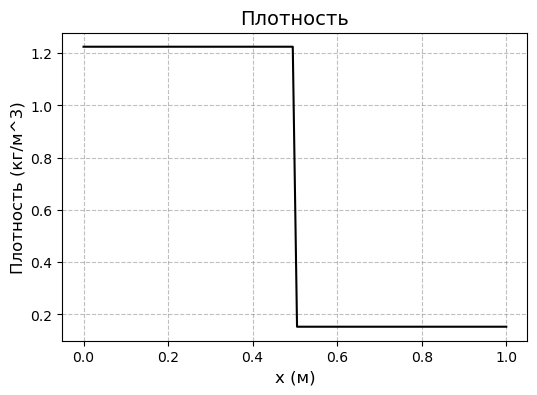

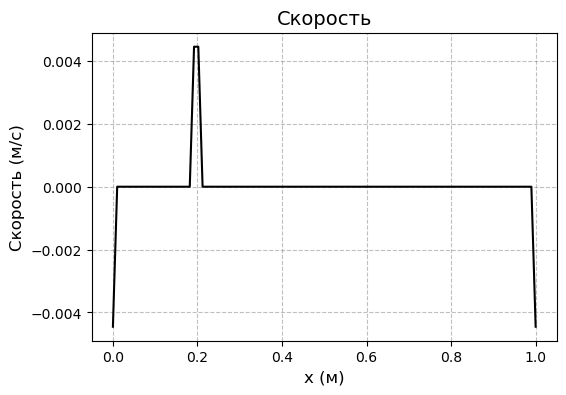

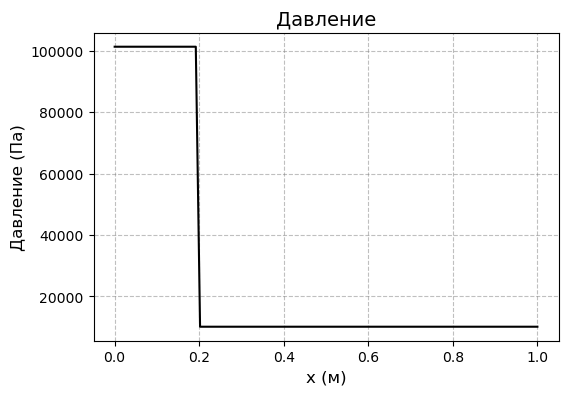

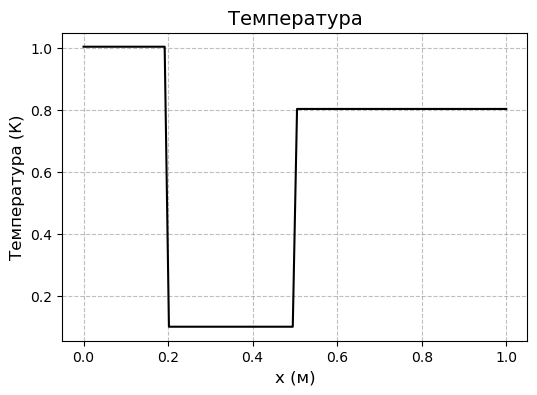

In [8]:
# --------------------- Параметры задачи ---------------------
gamma = 1.4
nx = 100         # Количество точек сетки 
xmin = 0.0
xmax = 1.0
dx = (xmax - xmin) / (nx - 1)


t_end = 0.0001      # Конечное время в секундах 
t_end = ConversionTime_in_Dim_less(t_end) # Перевод в безразмерное время
# dt берется просто равным половине от конечного времени
dt = t_end/2
# В дальнейшем в цикле dt вычисляется на основе безразмерного cfl
cfl = 0.5          # Число Куранта

# --------------- Инициализация сетки ---------------------
x = np.linspace(xmin, xmax, nx)
# --------------- Начальные условия (безразмерные, задача Сода) -----------------
rho_prime = np.ones(nx)
u_prime = np.zeros(nx)
p_prime = np.ones(nx)
T_prime = np.ones(nx)
rho_prime[x < 0.5] = 1.0
u_prime[x < 0.5] = 0.0
p_prime[x < 0.5] = 1.0
rho_prime[x >= 0.5] = 0.125
u_prime[x >= 0.2] = 0.0
p_prime[x >= 0.2] = 0.1
T_prime = p_prime/rho_prime/287
# --------------------- Перевод в размерные величины и обратно (СИ) ---------------------
# Этот переход сделан только для удобства обозначений, расчеты будут в безразмерных
x, rho, u, p, T = Conversion_in_Dim_quantities(x, rho_prime, u_prime, p_prime, T_prime)
x, rho, u, p, T = Conversion_in_Dim_less_quantities(x, rho, u, p, T)
# Дальнейший расчет идет в БЕЗРАЗМЕРНЫХ параметрах

# --------------------- Функция расчета потоков (теперь использует размерные переменные) ---------------------
def calculate_fluxes(rho, u, p, gamma):
    F_rho  = rho * u
    F_rhou = rho * u**2 + p
    F_rhoE    = (0.5*rho*u**2 + p/(gamma - 1))*u
    return F_rho, F_rhou, F_rhoE

# --------------------- Функция обновления переменных (RK4) ---------------------
def rk4_step(rho, u, p, dx, dt, gamma):
    E = p / (gamma - 1) + 0.5 * rho * u**2
    F_rho, F_rhou, F_rhoE = calculate_fluxes(rho, u, p, gamma)

    # k1
    drho_dt1  = - (np.roll(F_rho, -1) - np.roll(F_rho, 1)) / (2 * dx)
    drhou_dt1 = - (np.roll(F_rhou, -1) - np.roll(F_rhou, 1)) / (2 * dx)
    dE_dt1    = - (np.roll(F_rhoE, -1) - np.roll(F_rhoE, 1)) / (2 * dx)
    k1_rho  = dt * drho_dt1
    k1_rhou = dt * drhou_dt1
    k1_E    = dt * dE_dt1
    
    # k2
    rho_temp = rho + k1_rho / 2
    u_temp   = u + k1_rhou / (2*rho) / 2
    E_temp = E + k1_E / 2
    p_temp = (gamma - 1)*(E_temp - 0.5*rho_temp*u_temp**2)
    F_rho, F_rhou, F_rhoE = calculate_fluxes(rho_temp, u_temp, p_temp, gamma)
    drho_dt2  = - (np.roll(F_rho, -1) - np.roll(F_rho, 1)) / (2 * dx)
    drhou_dt2 = - (np.roll(F_rhou, -1) - np.roll(F_rhou, 1)) / (2 * dx)
    dE_dt2    = - (np.roll(F_rhoE, -1) - np.roll(F_rhoE, 1)) / (2 * dx)
    k2_rho  = dt * drho_dt2
    k2_rhou = dt * drhou_dt2
    k2_E    = dt * dE_dt2
        
    # k3
    rho_temp = rho + k2_rho / 2
    u_temp   = u + k2_rhou / (2*rho) / 2
    E_temp = E + k2_E / 2
    p_temp = (gamma - 1)*(E_temp - 0.5*rho_temp*u_temp**2)
    F_rho, F_rhou, F_rhoE = calculate_fluxes(rho_temp, u_temp, p_temp, gamma)
    drho_dt3  = - (np.roll(F_rho, -1) - np.roll(F_rho, 1)) / (2 * dx)
    drhou_dt3 = - (np.roll(F_rhou, -1) - np.roll(F_rhou, 1)) / (2 * dx)
    dE_dt3    = - (np.roll(F_rhoE, -1) - np.roll(F_rhoE, 1)) / (2 * dx)
    k3_rho  = dt * drho_dt3
    k3_rhou = dt * drhou_dt3
    k3_E    = dt * dE_dt3
        
    # k4
    rho_temp = rho + k3_rho
    u_temp   = u + k3_rhou / (2*rho)
    E_temp = E + k3_E
    p_temp = (gamma - 1)*(E_temp - 0.5*rho_temp*u_temp**2)
    F_rho, F_rhou, F_rhoE = calculate_fluxes(rho_temp, u_temp, p_temp, gamma)
    drho_dt4  = - (np.roll(F_rho, -1) - np.roll(F_rho, 1)) / (2 * dx)
    drhou_dt4 = - (np.roll(F_rhou, -1) - np.roll(F_rhou, 1)) / (2 * dx)
    dE_dt4    = - (np.roll(F_rhoE, -1) - np.roll(F_rhoE, 1)) / (2 * dx)
    k4_rho  = dt * drho_dt4
    k4_rhou = dt * drhou_dt4
    k4_E    = dt * dE_dt4

    # Обновление переменных
    rho = rho + (k1_rho + 2*k2_rho + 2*k3_rho + k4_rho) / 6
    u   = u   + (k1_rhou + 2*k2_rhou + 2*k3_rhou + k4_rhou) / 6
    E   = E   + (k1_E + 2*k2_E + 2*k3_E + k4_E) / 6
    p = (gamma - 1)*(E - 0.5*rho*u**2)
    return rho, u, p

# --------------------- Временная петля ---------------------
t = 0.0
print(t_end, dt)
while t < t_end:
    print(t)
    # Ограничение шага по времени (теперь с размерной скоростью звука)
    a = np.sqrt(gamma * p / rho)  #скорость звука
    dt = min(dt, cfl * dx / np.max(np.abs(u) + a)) # Шаг по времени связываем со скоростью звука
    rho, u, p = rk4_step(rho, u, p, dx, dt, gamma)
    T = p/(rho*287) # K
    t += dt


# --------------------- Визуализация результатов ---------------------

# Перевод в размерные значения
x, rho, u, p, T = Conversion_in_Dim_quantities(x, rho, u, p, T)


# Общие настройки для графиков
fig_size = (6, 4) 
line_color = 'black'
grid_linestyle = '--'
grid_alpha = 0.5
grid_color = 'gray'

def create_plot(x_data, y_data, x_label, y_label, title):
    plt.figure(figsize=fig_size) 
    plt.plot(x_data, y_data, color=line_color)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, linestyle=grid_linestyle, alpha=grid_alpha, color=grid_color)
    # plt.ylim(0,2) # Пример: установить предел по оси Y от 0 до 2
    plt.show()
    plt.close()

# Density plot
create_plot(x, rho, 'x (м)', 'Плотность (кг/м^3)', 'Плотность')
#del x, rho

# Velocity plot
x = np.linspace(xmin, xmax, nx)
create_plot(x, u, 'x (м)', 'Скорость (м/с)', 'Скорость')
#del x, u

# Pressure plot
x = np.linspace(xmin, xmax, nx)
create_plot(x, p, 'x (м)', 'Давление (Па)', 'Давление')
#del x, p
# Temperature plot
x = np.linspace(xmin, xmax, nx)
create_plot(x, T, 'x (м)', 'Температура (К)', 'Температура')
#del x, T

In [ ]:
#fig_size = (6, 4) 
#line_color = 'black'
#grid_linestyle = '--'
#grid_alpha = 0.5
#grid_color = 'gray'
    
def create_plot1(x_data, y_data, x_label, y_label, title):
    plt.figure(figsize=fig_size) 
    plt.plot(x_data, y_data, color=line_color)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, linestyle=grid_linestyle, alpha=grid_alpha, color=grid_color)
    # plt.ylim(0,2) # Пример: установить предел по оси Y от 0 до 2
    plt.show()
    plt.close()

def Visualization1(r, rho, u, p, T, message):
    # Общие настройки для графиков
    
    print(message)
    
    #Графики
    # Density plot
    create_plot(r, rho, 'r (м)', 'Плотность (кг/м^3)', 'Плотность')
    #del x, rho

    # Velocity plot
    create_plot(r, u, 'r (м)', 'Скорость (м/с)', 'Скорость')
    #del x, u

    # Pressure plot
    #x = np.linspace(xmin, xmax, nx)
    create_plot(r, p, 'x (м)', 'Давление (Па)', 'Давление')
    #del x, p
    # Temperature plot
    #x = np.linspace(xmin, xmax, nx)
    create_plot(r, T, 'x (м)', 'Температура (К)', 'Температура')
    #del x, T

### Cферически симметричный случай

In [3]:
gamma = 1.4 
rho0 = 1.225  # кг/м^3 (плотность воздуха на уровне моря)
p0   = 101325.0  # Па (атмосферное давление)
L0   = 1.0     # м (характерная длина)
U0   = np.sqrt(gamma*p0 / rho0) # м/с (характерная скорость, примерно скорость звука)
T0 = p0/(rho0*287) # K (Характерная температура)
t_0   = L0 / U0    # Характерное время (с)

def Conversion_in_Dim_quantities(x, rho, u, p, T):
    return x*L0, rho*rho0, u*U0, p*p0, T*T0

def Conversion_in_Dim_less_quantities(x, rho, u, p, T):
    return x/L0, rho/rho0, u/U0, p/p0, T/T0

def ConversionTime_in_Dim(t):
    return t*t_0

def ConversionTime_in_Dim_less(t):
    return t/t_0
print(rho0,p0,L0,U0,T0, t_0, sep='\n')

1.225
101325.0
1.0
340.29399054347107
288.20308611249374
0.002938635496921167


0.006348178220850256
Time: 0.000000
0.00634819240946328
Time: 0.000000
0.006348223617745592
Time: 0.000000
0.006348271832635824
Time: 0.000000
0.0063483370349890714
Time: 0.000000
0.0063484191994856495
Time: 0.000000
0.006348518294518754
Time: 0.000000
0.0063486342820525616
Time: 0.000000
0.0063487671174511226
Time: 0.000000
0.006348916749278382
Time: 0.000000
0.0063490831190698375
Time: 0.000000
0.006349266161076353
Time: 0.000000
0.006349465801980809
Time: 0.000000
0.006349681960588291
Time: 0.000000
0.006349914547490735
Time: 0.000000
nan
Time: 0.000000
nan
Time: 0.000000
nan
Time: 0.000001
nan
Time: 0.000001
nan
Time: 0.000001
nan
Time: 0.000001
nan
Time: 0.000001
nan
Time: 0.000001
nan
Time: 0.000001
nan
Time: 0.000001
nan
Time: 0.000001
nan
Time: 0.000001
nan
Time: 0.000001
nan
Time: 0.000001
nan
Time: 0.000001
nan
Time: 0.000001
nan
Time: 0.000001
nan
Time: 0.000001
nan
Time: 0.000001
nan
Time: 0.000001
nan
Time: 0.000001
nan
Time: 0.000001
nan
Time: 0.000001
nan
Time: 0.000001


C:\Users\izavo\AppData\Local\Temp\ipykernel_29424\2712008559.py:142: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(gamma * p / rho)  # скорость звука


Time: 0.000003
nan
Time: 0.000003
nan
Time: 0.000003
nan
Time: 0.000003
nan
Time: 0.000003
nan
Time: 0.000003
nan
Time: 0.000003
nan
Time: 0.000003
nan
Time: 0.000003
nan
Time: 0.000003
nan
Time: 0.000003
nan
Time: 0.000003


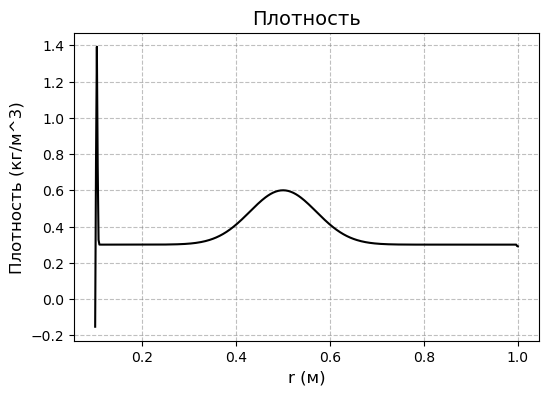

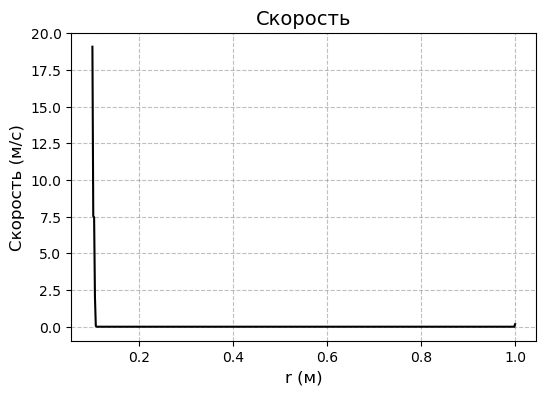

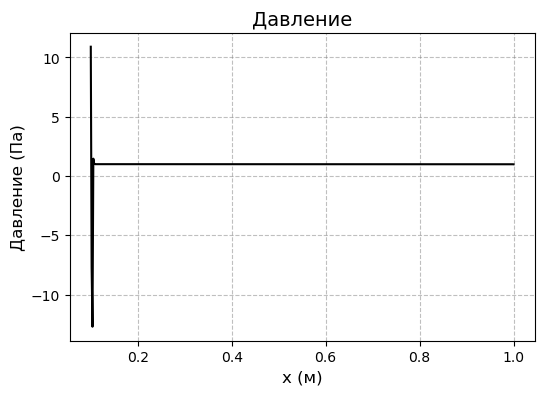

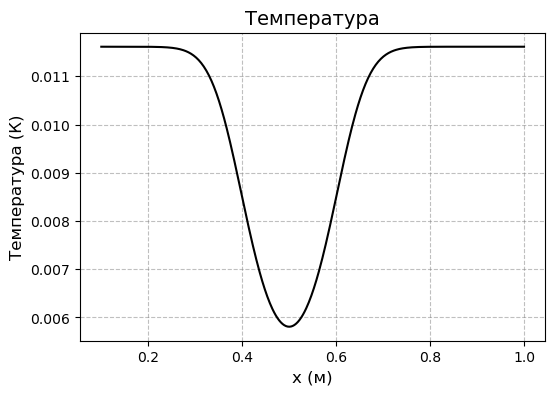

In [43]:
def Initial_Conditional(r_bound, r : list):
    rho = 0.3*np.ones(n_points) + 0.3*np.exp(-(r-0.5)**2/0.1**2)
    u = np.zeros(n_points)
    p = np.ones(n_points)
    T = np.ones(n_points)
    
    #rho[r >= r_bound] = 0.125
    #u[r >= r_bound] = 0.0
    #p[r >= r_bound] = 0.1
    T = p/rho/287
    
    return rho, u, p, T

def calculate_fluxes(rho, u, p, gamma, r): #Добавляем r в аргументы
    F_rho  = rho * u
    F_rhou = rho * u**2 + p
    F_rhoE    = (0.5*rho*u**2 + p/(gamma - 1))*u*rho
    return F_rho, F_rhou, F_rhoE

# --------------------- Функция обновления переменных (RK4) ---------------------
def rk4_step(rho, u, p, r, dr, dt, gamma): # Добавляем r в аргументы
    E = p / (gamma - 1) + 0.5 * rho * u**2
    F_rho, F_rhou, F_rhoE = calculate_fluxes(rho, u, p, gamma, r) #Добавляем r

    # Сферическая геометрия:  (1/r^2) * d/dr (r^2 * flux)
    # Мы используем центральные разности для d/dr и используем средние значения r^2

    # Функция для расчета r^2 * flux в узлах сетки
    def r_squared_flux(r, flux):
        return r**2 * flux

    # k1
    r2F_rho = r_squared_flux(r, F_rho)
    r2F_rhou = r_squared_flux(r, F_rhou)
    r2F_rhoE = r_squared_flux(r, F_rhoE)

    #Вычисляем производную используя центральную разность
    drho_dt1  = - (np.roll(r2F_rho, -1) - np.roll(r2F_rho, 1)) / (2 * dr) / r**2 #Добавляем /r**2
    drhou_dt1 = - (np.roll(r2F_rhou, -1) - np.roll(r2F_rhou, 1)) / (2 * dr) / r**2 + 2*p/r  #Добавляем /r**2  + 2p/r
    dE_dt1    = - (np.roll(r2F_rhoE, -1) - np.roll(r2F_rhoE, 1)) / (2 * dr) / r**2 #Добавляем /r**2

    k1_rho  = dt * drho_dt1
    k1_rhou = dt * drhou_dt1
    k1_E    = dt * dE_dt1

    # k2
    rho_temp = rho + k1_rho / 2
    u_temp   = u + k1_rhou / (2*rho) / 2
    E_temp = E + k1_E / 2
    p_temp = (gamma - 1)*(E_temp - 0.5*rho_temp*u_temp**2)
    F_rho, F_rhou, F_rhoE = calculate_fluxes(rho_temp, u_temp, p_temp, gamma, r) #Добавляем r

    r2F_rho = r_squared_flux(r, F_rho)
    r2F_rhou = r_squared_flux(r, F_rhou)
    r2F_rhoE = r_squared_flux(r, F_rhoE)

    drho_dt2  = - (np.roll(r2F_rho, -1) - np.roll(r2F_rho, 1)) / (2 * dr) / r**2  #Добавляем /r**2
    drhou_dt2 = - (np.roll(r2F_rhou, -1) - np.roll(r2F_rhou, 1)) / (2 * dr) / r**2  + 2*p_temp/r#Добавляем /r**2  + 2p/r
    dE_dt2    = - (np.roll(r2F_rhoE, -1) - np.roll(r2F_rhoE, 1)) / (2 * dr) / r**2#Добавляем /r**2

    k2_rho  = dt * drho_dt2
    k2_rhou = dt * drhou_dt2
    k2_E    = dt * dE_dt2

    # k3
    rho_temp = rho + k2_rho / 2
    u_temp   = u + k2_rhou / (2*rho) / 2
    E_temp = E + k2_E / 2
    p_temp = (gamma - 1)*(E_temp - 0.5*rho_temp*u_temp**2)
    F_rho, F_rhou, F_rhoE = calculate_fluxes(rho_temp, u_temp, p_temp, gamma, r)#Добавляем r

    r2F_rho = r_squared_flux(r, F_rho)
    r2F_rhou = r_squared_flux(r, F_rhou)
    r2F_rhoE = r_squared_flux(r, F_rhoE)

    drho_dt3  = - (np.roll(r2F_rho, -1) - np.roll(r2F_rho, 1)) / (2 * dr) / r**2 #Добавляем /r**2
    drhou_dt3 = - (np.roll(r2F_rhou, -1) - np.roll(r2F_rhou, 1)) / (2 * dr) / r**2  + 2*p_temp/r#Добавляем /r**2  + 2p/r
    dE_dt3    = - (np.roll(r2F_rhoE, -1) - np.roll(r2F_rhoE, 1)) / (2 * dr) / r**2#Добавляем /r**2

    k3_rho  = dt * drho_dt3
    k3_rhou = dt * drhou_dt3
    k3_E    = dt * dE_dt3

    # k4
    rho_temp = rho + k3_rho
    u_temp   = u + k3_rhou / (2*rho)
    E_temp = E + k3_E
    p_temp = (gamma - 1)*(E_temp - 0.5*rho_temp*u_temp**2)
    F_rho, F_rhou, F_rhoE = calculate_fluxes(rho_temp, u_temp, p_temp, gamma,r)#Добавляем r

    r2F_rho = r_squared_flux(r, F_rho)
    r2F_rhou = r_squared_flux(r, F_rhou)
    r2F_rhoE = r_squared_flux(r, F_rhoE)

    drho_dt4  = - (np.roll(r2F_rho, -1) - np.roll(r2F_rho, 1)) / (2 * dr) / r**2#Добавляем /r**2
    drhou_dt4 = - (np.roll(r2F_rhou, -1) - np.roll(r2F_rhou, 1)) / (2 * dr) / r**2 + 2*p_temp/r #Добавляем /r**2  + 2p/r
    dE_dt4    = - (np.roll(r2F_rhoE, -1) - np.roll(r2F_rhoE, 1)) / (2 * dr) / r**2#Добавляем /r**2

    k4_rho  = dt * drho_dt4
    k4_rhou = dt * drhou_dt4
    k4_E    = dt * dE_dt4

    # Обновление переменных
    rho = rho + (k1_rho + 2*k2_rho + 2*k3_rho + k4_rho) / 6
    u   = u   + (k1_rhou + 2*k2_rhou + 2*k3_rhou + k4_rhou) / 6
    E   = E   + (k1_E + 2*k2_E + 2*k3_E + k4_E) / 6
    p = (gamma - 1)*(E - 0.5*rho*u**2)

    return rho, u, p

# ----------- Инициализация сетки и переменных (сферическая геометрия) -----------
n_points = 500 # Number of grid points
r_min = 0.1    # Minimum radius (avoiding r=0 exactly)
r_max = 1.0    # Maximum radius
r = np.linspace(r_min, r_max, n_points)  # Радиальная координата
dr = r[1] - r[0]  # Шаг по радиусу

# -----------  Инициализация переменных (пример) -----------


gamma = 1.4                  # Показатель адиабаты

#r, rho, u, p, T = r, rho_prime, u_prime, p_prime, T_prime
rho, u, p, T = Initial_Conditional(r[2], r)
#print("#0:", rho, u, p, T)
r, rho, u, p, T = Conversion_in_Dim_quantities(r, rho, u, p, T)
#print("#1:", rho, u, p, T)
r, rho, u, p, T = Conversion_in_Dim_less_quantities(r, rho, u, p, T)
#print("#2:", rho, u, p, T)
# ----------- Временные параметры -----------
t      = 0.0
t_end_dim  = 0.001 #  В секундах
cfl    = 0.4     # CFL number (adjust as needed)
dt_dim     = 1.0e-5  # Initial time step (adjust as needed)
#t_end_prime, dt_prime = ConversionTime_in_Dim_less(t_end_dim), ConversionTime_in_Dim_less(dt_dim)
#print(t_end_prime, dt_prime)
t_end, dt = t_end_dim, dt_dim#ConversionTime_in_Dim_less(t_end_dim), ConversionTime_in_Dim_less(dt_dim)

#  ----------- Основной цикл времени -----------
while t < t_end:
    # Ограничение шага по времени (теперь с размерной скоростью звука)
    a = np.sqrt(gamma * p / rho)  # скорость звука
    dt = min(dt, cfl * dr / np.max(np.abs(u) + a))  # Шаг по времени
    print(max(a/U0))
    
    rho, u, p = rk4_step(rho, u, p, r, dr, dt, gamma)  # Передаем r и dr
    t += dt
    print(f"Time: {ConversionTime_in_Dim(t):.6f}")


#print(rho)
# Общие настройки для графиков
fig_size = (6, 4) 
line_color = 'black'
grid_linestyle = '--'
grid_alpha = 0.5
grid_color = 'gray'

def create_plot(x_data, y_data, x_label, y_label, title):
    plt.figure(figsize=fig_size) 
    plt.plot(x_data, y_data, color=line_color)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, linestyle=grid_linestyle, alpha=grid_alpha, color=grid_color)
    # plt.ylim(0,2) # Пример: установить предел по оси Y от 0 до 2
    plt.show()
    plt.close()

r = np.linspace(r_min, r_max, n_points)

# Density plot
create_plot(r, rho, 'r (м)', 'Плотность (кг/м^3)', 'Плотность')
#del x, rho

# Velocity plot
create_plot(r, u, 'r (м)', 'Скорость (м/с)', 'Скорость')
#del x, u

# Pressure plot
#x = np.linspace(xmin, xmax, nx)
create_plot(r, p, 'x (м)', 'Давление (Па)', 'Давление')
#del x, p
# Temperature plot
#x = np.linspace(xmin, xmax, nx)
create_plot(r, T, 'x (м)', 'Температура (К)', 'Температура')
#del x, T

##### Некоторые тесты сферически симметричного случая

1) Начальное условие: возмущение в плотности, должна быть скорость звука
ρ(r, 0) = ρ₀ + A * exp(-(r - r₀)² / σ²) (ρ₀ - средняя плотность, A - амплитуда возмущения, r₀ - положение центра возмущения, σ - ширина возмущения)
u(r, 0) = 0
p(r, 0) = p₀ (постоянное давление)